In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

In [18]:
df = pd.read_csv("/Users/chris/projects/Nature2023MooneyScripts/results/learning_comparison.csv")

In [19]:
df.head()

,Source,Detailed source,Subject,Image index,Phase,Correct,Predicted,Ground truth class
0,Human,Human-0,0,0,pre,1,???,dog
1,Human,Human-0,0,0,gray,1,???,dog
2,Human,Human-0,0,0,post,1,???,dog
3,Human,Human-1,1,0,pre,0,???,dog
4,Human,Human-1,1,0,gray,1,???,dog


## Find which classes the model couldn't possibly get

In [20]:
to_parse = df[df["Source"] != "Human"]

In [21]:
target_class = df["Ground truth class"]

In [22]:
pred_class = df["Predicted"]

In [23]:
import json

# Load the mapping
mapping = json.load(open("../../data/imagenet_label_to_wordnet_synset.json"))
behavior_mapping = json.load(open("../../data/wordnet_translation.json"))

In [24]:
from nltk.corpus import wordnet as wn

In [25]:
mapper_imagenet_name_2_wn_synset = {}

unknown_class = []
all_target_classes = set(target_class)
for c in all_target_classes:
    has_match = False
    for imagenet_class_d in mapping.values():

        # Get the synset of imagenet class
        synset = wn.synset_from_pos_and_offset("n", int(imagenet_class_d["id"].split("-")[0]))

        if imagenet_class_d["label"] not in mapper_imagenet_name_2_wn_synset:
            mapper_imagenet_name_2_wn_synset[imagenet_class_d["label"]] = synset

        # Get the synset of the target class
        target_synset = wn.synset(behavior_mapping[c])

        # If has a match
        if target_synset in synset.lowest_common_hypernyms(target_synset):
            has_match = True

    if not has_match:
        unknown_class.append(c)

In [26]:
unknown_class

['cannon',
 'helicopter',
 'bonsai',
 'statue',
 'castle',
 'barrel',
 'anchor',
 'chandelier',
 'ox',
 'palace']

## Convert the classes to model's

In [27]:
# Mark removal of unknown classes
df["to_remove"] = False
for idx, row in df.iterrows():
    if row["Correct"] in ["0", "1"]:
        # If the class is unknown, remove it
        target_name = row["Ground truth class"]
        if target_name in unknown_class:
            df.loc[idx, "to_remove"] = True
        else:
            df.loc[idx, "Correct"] = int(row["Correct"])
    else:
        target_name = row["Ground truth class"]
        pred_name = row["Predicted"]

        # If the class is unknown, remove it
        if target_name in unknown_class:
            df.loc[idx, "to_remove"] = True
        else:
            # This should be ignored
            if pred_name == "crane2":
                pred_name = "crane"

            # If the lowest common hypernym is the ground truth, count as correct
            imagenet_class_synset = mapper_imagenet_name_2_wn_synset[pred_name]

            # Get the groundtruth synset
            gt_synset = wn.synset(behavior_mapping[target_name])

            # Get the LCH
            lch = imagenet_class_synset.lowest_common_hypernyms(gt_synset)
            if any([lch_synset == gt_synset for lch_synset in lch]):
                df.loc[idx, "Correct"] = 1
            else:
                df.loc[idx, "Correct"] = 0

df = df[~df["to_remove"]]
df["Correct"].unique()

array([1, 0], dtype=object)

In [28]:
df = df.drop(columns=["to_remove", "Ground truth class", "Predicted"])
df["Correct"] = df["Correct"].astype(int)
df.head()

,Source,Detailed source,Subject,Image index,Phase,Correct
0,Human,Human-0,0,0,pre,1
1,Human,Human-0,0,0,gray,1
2,Human,Human-0,0,0,post,1
3,Human,Human-1,1,0,pre,0
4,Human,Human-1,1,0,gray,1


## Performance comparison

In [29]:
# Aggregate by subject and source
agg_df = df.drop(columns=["Image index"])
agg_df = agg_df.groupby(["Subject", "Source", "Phase"]).mean(numeric_only=True).reset_index()
agg_df.head(6)

,Subject,Source,Phase,Correct
0,0,Human,gray,0.786885
1,0,Human,post,0.579235
2,0,Human,pre,0.415301
3,0,Model,gray,0.796448
4,0,Model,post,0.620219
5,0,Model,pre,0.393443


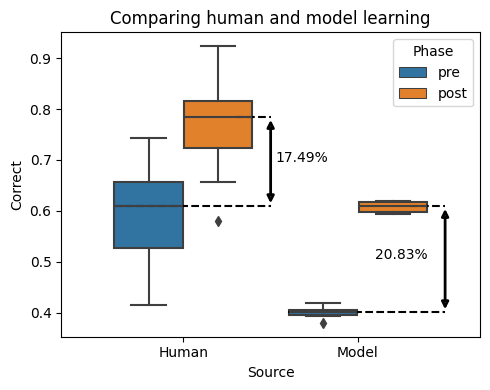

In [30]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=agg_df, x="Source", y="Correct", hue="Phase", hue_order=["pre", "post"])

# Plot the differences
mean_pre_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "pre")]["Correct"].median()
mean_post_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "post")]["Correct"].median()
plt.plot([-0.4, 0.5], [mean_pre_human, mean_pre_human], color="k", linestyle="--")
plt.plot([0.3, 0.5], [mean_post_human, mean_post_human], color="k", linestyle="--")

# Draw arrow between their means
plt.annotate('', xy=(0.5, mean_pre_human), xytext=(0.5, mean_post_human),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_human - mean_pre_human):.2f}%', xy=(0.53, (mean_post_human + mean_pre_human) / 2))

# Plot the differences
mean_pre_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "pre")]["Correct"].median()
mean_post_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "post")]["Correct"].median()
plt.plot([1-0.4, 1.5], [mean_pre_model, mean_pre_model], color="k", linestyle="--")
plt.plot([1.3, 1.5], [mean_post_model, mean_post_model], color="k", linestyle="--")

# Draw arrow between their means
plt.annotate('', xy=(1.5, mean_pre_model), xytext=(1.5, mean_post_model),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_model - mean_pre_model):.2f}%', xy=(1.1, (mean_post_model + mean_pre_model) / 2))

# Turn off boundary
plt.title("Comparing human and model learning")
plt.tight_layout()

In [41]:
mean_post_human, mean_post_model

(0.7841530054644809, 0.6092896174863387)

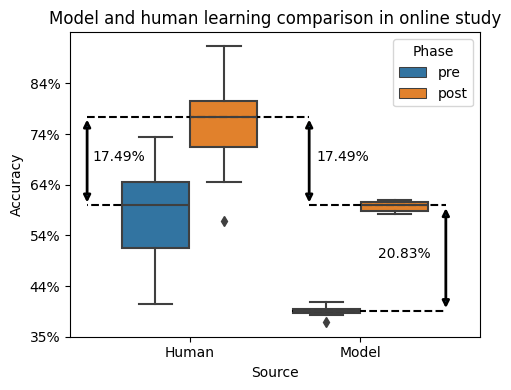

In [40]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=agg_df, x="Source", y="Correct", hue="Phase", hue_order=["pre", "post"])

# Plot the differences
mean_pre_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "pre")]["Correct"].median()
mean_post_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "post")]["Correct"].median()
plt.plot([-0.4, -0.6], [mean_pre_human, mean_pre_human], color="k", linestyle="--")
plt.plot([-0.6, 0.7], [mean_post_human, mean_post_human], color="k", linestyle="--")

# Draw arrow between their means
plt.annotate('', xy=(-0.6, mean_pre_human), xytext=(-0.6, mean_post_human),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_human - mean_pre_human):.2f}%', xy=(-0.57, (mean_post_human + mean_pre_human) / 2))

# Plot the differences
mean_pre_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "pre")]["Correct"].median()
mean_post_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "post")]["Correct"].median()
plt.plot([1-0.4, 1.5], [mean_pre_model, mean_pre_model], color="k", linestyle="--")
plt.plot([0.7, 1.5], [mean_post_model, mean_post_model], color="k", linestyle="--")

# Draw arrow between their means
plt.annotate('', xy=(1.5, mean_pre_model), xytext=(1.5, mean_post_model),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_model - mean_pre_model):.2f}%', xy=(1.1, (mean_post_model + mean_pre_model) / 2))

# Draw arrow between model and human post mean
plt.annotate('', xy=(0.7, mean_post_human), xytext=(0.7, mean_post_model),
             arrowprops=dict(arrowstyle='<|-|>', lw=2))
plt.annotate(f'{100 * (mean_post_human - mean_post_model):.2f}%', xy=(0.74, (mean_post_human + mean_post_model) / 2))

# Make y axis Accuracy percentage
plt.yticks(np.arange(0.35, 0.9, 0.1), [f"{int(100 * i)}%" for i in np.arange(0.35, 0.9, 0.1)])
plt.ylabel("Accuracy")

# Turn off boundary
plt.title("Model and human learning comparison in online study")
plt.tight_layout()

<Axes: xlabel='Phase', ylabel='Correct'>

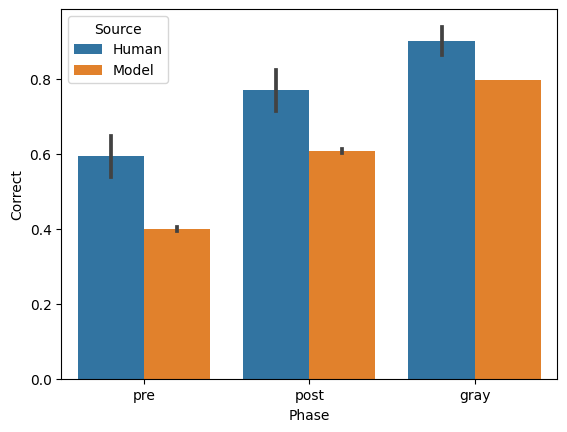

In [32]:
sns.barplot(data=agg_df, x="Phase", y="Correct", hue="Source", order=["pre", "post", "gray"])

## Behavioral similarity matrix

In [33]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


def plot_performance_comparison(df, phase, measure, show_ticks=False):
    curr_df = df[df["Phase"] == phase]

    # This only has effect on the models
    curr_df = curr_df.groupby(["Subject", "Source", "Image index"]).mean(numeric_only=True).reset_index()

    # Binarize
    curr_df = curr_df.assign(Correct=curr_df["Correct"] > 0.5)
    curr_df["Subject-Source"] =  curr_df["Source"] + "-" + curr_df["Subject"].astype(str)

    container = {
        "src": [],
        "dest": [],
        "type": [],
        "similarity": []
    }

    for src, dest in product(curr_df["Subject-Source"].unique(), repeat=2):
        src_df = curr_df[curr_df["Subject-Source"] == src]
        dest_df = curr_df[curr_df["Subject-Source"] == dest]

        # Order by image index
        src_df = src_df.sort_values(by="Image index")
        dest_df = dest_df.sort_values(by="Image index")

        types = []

        # What type of interaction is this?
        if "model" in src.lower():
            types.append("model")
        else:
            types.append("human")

        if "model" in dest.lower():
            types.append("model")
        else:
            types.append("human")

        container["type"].append("->".join(types))

        # Append to container
        container["src"].append(src)
        container["dest"].append(dest)
        container["similarity"].append(measure(src_df["Correct"], dest_df["Correct"]))

    # Create a dataframe
    df = pd.DataFrame(container)

    # Get the matrix
    pivoted = pd.pivot_table(df, index="src", columns="dest", values="similarity", aggfunc=np.mean)

    # Draw the heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(pivoted, linewidth=1, linecolor='w', square=True, ax=ax, cmap="coolwarm", vmin=-1, vmax=1)

    # Turn off x, y label
    plt.xlabel("")
    plt.ylabel("")

    ax.set_title(f"Similarity of decision making in {phase} phase")
    fig.tight_layout()
    plt.show()

    return pivoted, df

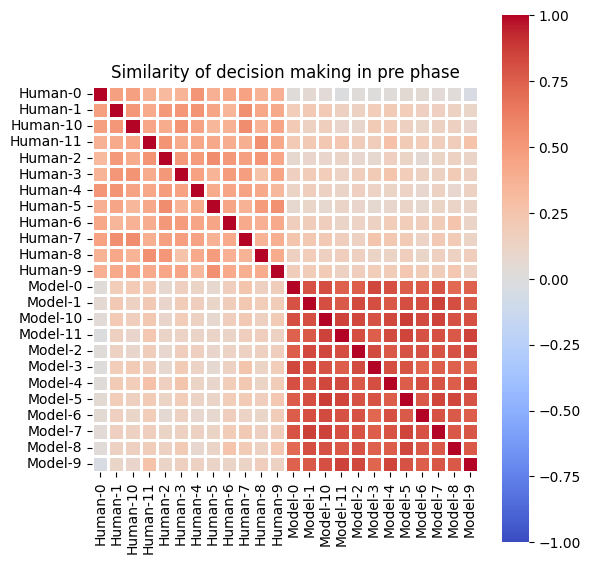

In [34]:
from scipy.stats import pearsonr
_, sim_df = plot_performance_comparison(df, "pre", measure=lambda x,y: pearsonr(x, y)[0], show_ticks=True)
None

<Axes: xlabel='Decision Similarity', ylabel='Density'>

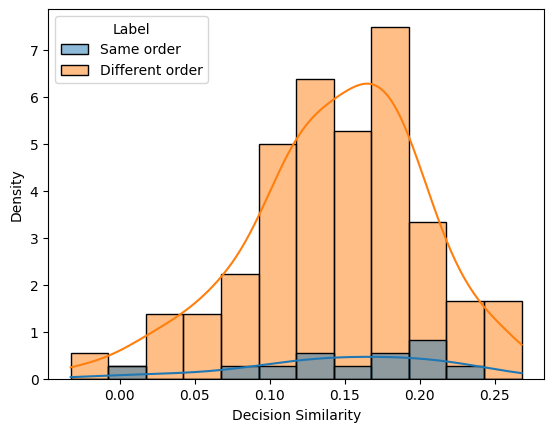

In [35]:
# Remove symmetric version
sim_df = sim_df[sim_df["src"].str.contains("Model") & sim_df["dest"].str.contains("Human")]
sim_df["src"] = sim_df["src"].str.replace("Model-", "")
sim_df["dest"] = sim_df["dest"].str.replace("Human-", "")
sim_df.drop(columns="type", inplace=True)
sim_df = sim_df.reset_index(drop=True)
mtx = sim_df.pivot(index="src", columns="dest", values="similarity").values

# Plot the histogram of diagonal vs off-diagonal
d1 = mtx.diagonal()
d2 = mtx[~np.eye(mtx.shape[0], dtype=bool)]

d = pd.DataFrame({
    "Decision Similarity": np.concatenate([d1, d2]),
    "Label": ["Same order"] * len(d1) + ["Different order"] * len(d2)
})
sns.histplot(data=d, x="Decision Similarity", hue="Label", kde=True, stat="density")

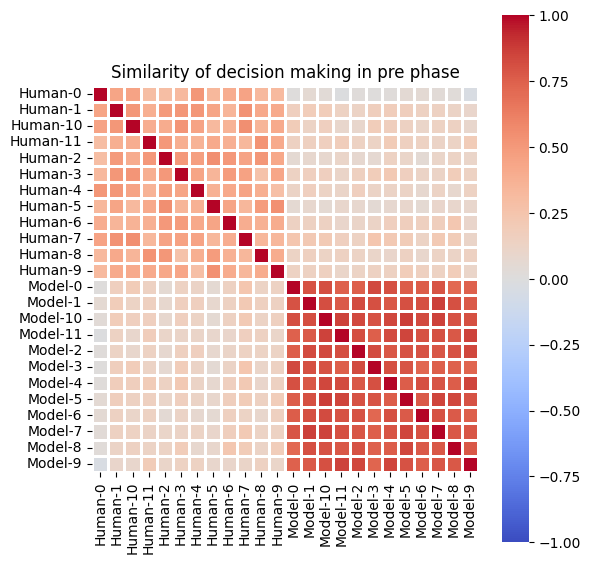

In [36]:
# Get DICE distance between two vectors
from sklearn.metrics import cohen_kappa_score
_, sim_df = plot_performance_comparison(df, "pre", measure=lambda x,y: cohen_kappa_score(x, y), show_ticks=True)
None

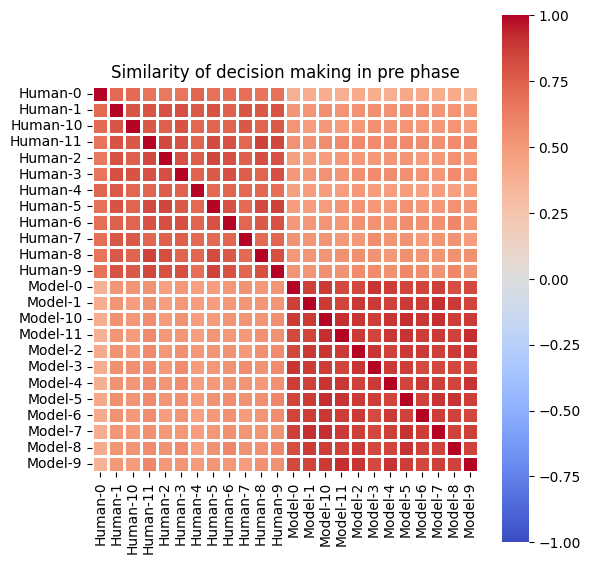

In [38]:
# Get DICE distance between two vectors
from scipy.spatial.distance import dice
pivoted_dice_df, sim_df = plot_performance_comparison(df, "pre", measure=lambda x,y: 1-dice(x, y), show_ticks=True)